# Hospital Readmission Prediction Model


=== Hospital Readmission Prediction Model ===

Generating synthetic patient data...
Preprocessing data...
  - Creating new features...
  - Encoding categorical variables...
  - Handling missing values...
  - Final dataset shape: (1000, 14)
  - Readmission rate: 50.90%
Training logistic regression model...
  - Training set size: 600
  - Validation set size: 200
  - Test set size: 200
  - Cross-validation accuracy: 0.622 (+/- 0.017)
Evaluating model performance...
  - Precision: 0.598
  - Recall: 0.539
  - F1-Score: 0.567


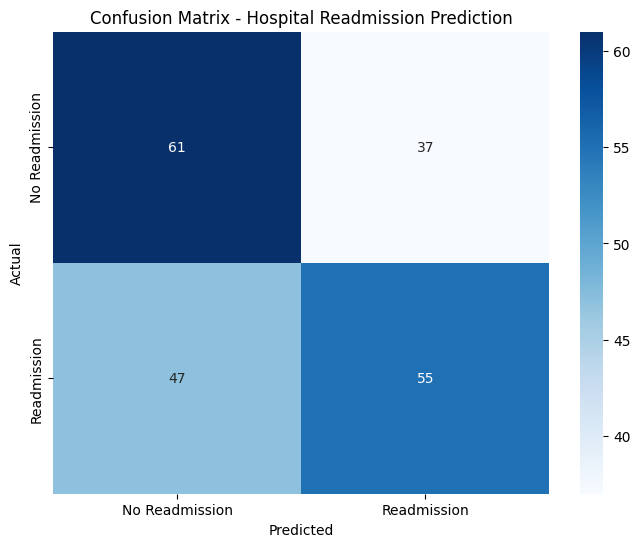


Detailed Classification Report:
                precision    recall  f1-score   support

No Readmission       0.56      0.62      0.59        98
   Readmission       0.60      0.54      0.57       102

      accuracy                           0.58       200
     macro avg       0.58      0.58      0.58       200
  weighted avg       0.58      0.58      0.58       200


Top 10 Most Important Features:
                   feature  coefficient  abs_coefficient
4       chronic_conditions     0.492640         0.492640
0                      age     0.463550         0.463550
3          num_medications     0.307547         0.307547
2           length_of_stay     0.292432         0.292432
11                 elderly    -0.287779         0.287779
5      previous_admissions     0.227342         0.227342
6      emergency_admission     0.188191         0.188191
10            polypharmacy    -0.068599         0.068599
12     frequent_admissions    -0.065619         0.065619
9   distance_from_hospita

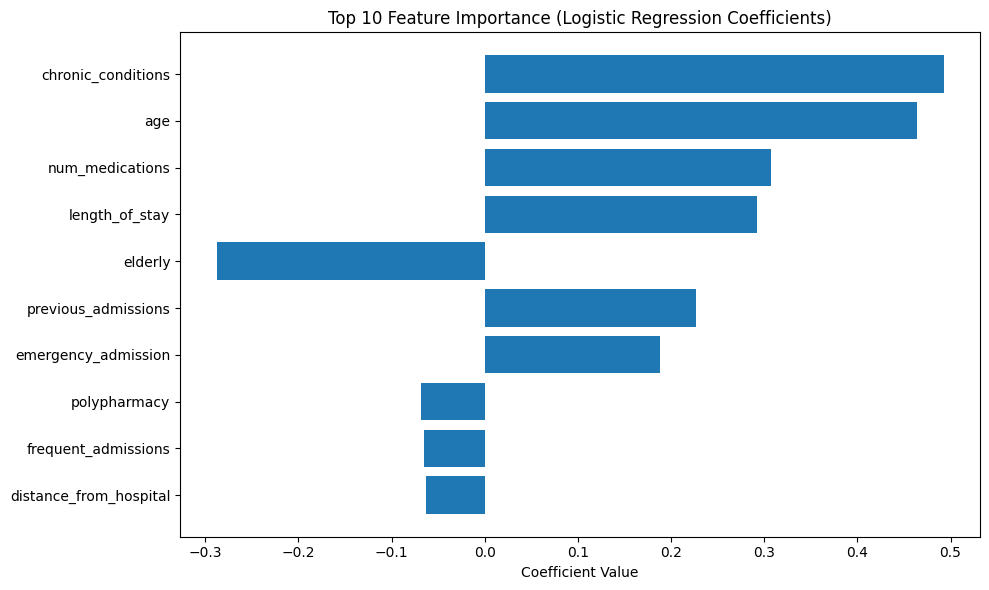

Manual Confusion Matrix Calculation:
  - True Negatives (correctly predicted no readmission): 61
  - False Positives (incorrectly predicted readmission): 37
  - False Negatives (missed actual readmissions): 47
  - True Positives (correctly predicted readmission): 55

Manual Metric Calculations:
  - Precision = TP/(TP+FP) = 55/(55+37) = 0.598
  - Recall = TP/(TP+FN) = 55/(55+47) = 0.539
  - Accuracy = (TP+TN)/Total = (55+61)/200 = 0.580
Example: Predicting readmission risk for a new patient...
  - Predicted readmission: Yes
  - Readmission probability: 85.87%
  - Recommendation: HIGH RISK - Provide intensive discharge planning

=== Model Training Complete ===
This model is ready for integration into hospital EHR systems!


In [14]:
# This code implements a logistic regression model to predict 30-day readmission risk

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

def generate_sample_data(n_samples=1000):
    """
    Generate synthetic hospital patient data for demonstration
    In real implementation, this would come from EHR system
    """
    print("Generating synthetic patient data...")

    # Create synthetic patient data
    data = {
        'age': np.random.normal(65, 15, n_samples),  # Average age 65
        'gender': np.random.choice(['M', 'F'], n_samples),
        'length_of_stay': np.random.exponential(5, n_samples),  # Days in hospital
        'num_medications': np.random.poisson(7, n_samples),  # Number of medications
        'chronic_conditions': np.random.poisson(2, n_samples),  # Number of chronic conditions
        'previous_admissions': np.random.poisson(1, n_samples),  # Previous admissions in last year
        'emergency_admission': np.random.choice([0, 1], n_samples, p=[0.3, 0.7]),  # 1 = emergency, 0 = planned
        'insurance_type': np.random.choice(['Medicare', 'Medicaid', 'Private', 'Uninsured'], n_samples),
        'discharge_destination': np.random.choice(['Home', 'Nursing_Home', 'Rehab'], n_samples, p=[0.7, 0.2, 0.1]),
        'distance_from_hospital': np.random.exponential(10, n_samples),  # Miles from hospital
    }

    # Create DataFrame
    df = pd.DataFrame(data)

    # Clean up data to make it realistic
    df['age'] = np.clip(df['age'], 18, 100)  # Age between 18-100
    df['length_of_stay'] = np.clip(df['length_of_stay'], 1, 30)  # Stay between 1-30 days
    df['num_medications'] = np.clip(df['num_medications'], 0, 20)  # 0-20 medications
    df['chronic_conditions'] = np.clip(df['chronic_conditions'], 0, 10)  # 0-10 conditions
    df['distance_from_hospital'] = np.clip(df['distance_from_hospital'], 0.1, 100)  # 0.1-100 miles

    # Create readmission target based on realistic factors
    # Higher risk factors: older age, more chronic conditions, longer stay, more medications
    readmission_probability = (
        0.1 +  # Base probability
        0.001 * df['age'] +  # Age factor
        0.05 * df['chronic_conditions'] +  # Chronic conditions
        0.02 * df['num_medications'] +  # Medications
        0.01 * df['length_of_stay'] +  # Length of stay
        0.03 * df['previous_admissions'] +  # Previous admissions
        0.05 * df['emergency_admission'] +  # Emergency admission
        0.02 * (df['insurance_type'] == 'Uninsured').astype(int)  # Uninsured factor
    )

    # Add some random noise and create binary outcome
    readmission_probability += np.random.normal(0, 0.1, n_samples)
    df['readmitted_30_days'] = (np.random.random(n_samples) < readmission_probability).astype(int)

    return df

def preprocess_data(df):
    """
    Preprocess the patient data for machine learning
    """
    print("Preprocessing data...")

    # Create a copy to avoid modifying original data
    processed_df = df.copy()

    # Feature Engineering
    print("  - Creating new features...")

    # Create polypharmacy flag (taking more than 5 medications)
    processed_df['polypharmacy'] = (processed_df['num_medications'] > 5).astype(int)

    # Create high-risk age flag (over 75)
    processed_df['elderly'] = (processed_df['age'] > 75).astype(int)

    # Create frequent flyer flag (more than 2 previous admissions)
    processed_df['frequent_admissions'] = (processed_df['previous_admissions'] > 2).astype(int)

    # Create long stay flag (more than 7 days)
    processed_df['long_stay'] = (processed_df['length_of_stay'] > 7).astype(int)

    # Handle categorical variables
    print("  - Encoding categorical variables...")

    # Label encode categorical variables
    le_gender = LabelEncoder()
    processed_df['gender_encoded'] = le_gender.fit_transform(processed_df['gender'])

    le_insurance = LabelEncoder()
    processed_df['insurance_encoded'] = le_insurance.fit_transform(processed_df['insurance_type'])

    le_discharge = LabelEncoder()
    processed_df['discharge_encoded'] = le_discharge.fit_transform(processed_df['discharge_destination'])

    # Handle missing values (simulate some missing data)
    print("  - Handling missing values...")

    # Randomly set some values to missing to simulate real-world data
    missing_mask = np.random.random(len(processed_df)) < 0.05  # 5% missing
    processed_df.loc[missing_mask, 'distance_from_hospital'] = np.nan

    # Impute missing values
    imputer = SimpleImputer(strategy='median')
    processed_df['distance_from_hospital'] = imputer.fit_transform(
        processed_df[['distance_from_hospital']]
    ).flatten()

    # Select features for modeling
    feature_columns = [
        'age', 'gender_encoded', 'length_of_stay', 'num_medications',
        'chronic_conditions', 'previous_admissions', 'emergency_admission',
        'insurance_encoded', 'discharge_encoded', 'distance_from_hospital',
        'polypharmacy', 'elderly', 'frequent_admissions', 'long_stay'
    ]

    X = processed_df[feature_columns]
    y = processed_df['readmitted_30_days']

    print(f"  - Final dataset shape: {X.shape}")
    print(f"  - Readmission rate: {y.mean():.2%}")

    return X, y, feature_columns

def train_model(X, y):
    """
    Train the logistic regression model
    """
    print("Training logistic regression model...")

    # Split data into train/validation/test sets
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

    print(f"  - Training set size: {len(X_train)}")
    print(f"  - Validation set size: {len(X_val)}")
    print(f"  - Test set size: {len(X_test)}")

    # Scale features (important for logistic regression)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Train logistic regression model
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_train_scaled, y_train)

    # Cross-validation to check for overfitting
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    print(f"  - Cross-validation accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

    return model, scaler, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

def evaluate_model(model, X_test, y_test, feature_names):
    """
    Evaluate the model and create confusion matrix
    """
    print("Evaluating model performance...")

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of readmission

    # Calculate metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"  - Precision: {precision:.3f}")
    print(f"  - Recall: {recall:.3f}")
    print(f"  - F1-Score: {f1:.3f}")

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Readmission', 'Readmission'],
                yticklabels=['No Readmission', 'Readmission'])
    plt.title('Confusion Matrix - Hospital Readmission Prediction')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Print detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Readmission', 'Readmission']))

    # Show feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'coefficient': model.coef_[0],
        'abs_coefficient': np.abs(model.coef_[0])
    }).sort_values('abs_coefficient', ascending=False)

    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    top_features = feature_importance.head(10)
    plt.barh(range(len(top_features)), top_features['coefficient'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Coefficient Value')
    plt.title('Top 10 Feature Importance (Logistic Regression Coefficients)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    return cm, y_pred, y_pred_proba

def calculate_confusion_matrix_manually(y_true, y_pred):
    """
    Calculate confusion matrix manually to show the math
    """
    print("Manual Confusion Matrix Calculation:")

    # Calculate each component
    true_negatives = np.sum((y_true == 0) & (y_pred == 0))
    false_positives = np.sum((y_true == 0) & (y_pred == 1))
    false_negatives = np.sum((y_true == 1) & (y_pred == 0))
    true_positives = np.sum((y_true == 1) & (y_pred == 1))

    print(f"  - True Negatives (correctly predicted no readmission): {true_negatives}")
    print(f"  - False Positives (incorrectly predicted readmission): {false_positives}")
    print(f"  - False Negatives (missed actual readmissions): {false_negatives}")
    print(f"  - True Positives (correctly predicted readmission): {true_positives}")

    # Manual calculation of metrics
    precision_manual = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall_manual = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    accuracy_manual = (true_positives + true_negatives) / len(y_true)

    print(f"\nManual Metric Calculations:")
    print(f"  - Precision = TP/(TP+FP) = {true_positives}/({true_positives}+{false_positives}) = {precision_manual:.3f}")
    print(f"  - Recall = TP/(TP+FN) = {true_positives}/({true_positives}+{false_negatives}) = {recall_manual:.3f}")
    print(f"  - Accuracy = (TP+TN)/Total = ({true_positives}+{true_negatives})/{len(y_true)} = {accuracy_manual:.3f}")

    return np.array([[true_negatives, false_positives], [false_negatives, true_positives]])

def predict_new_patient(model, scaler, feature_names):
    """
    Example of how to use the model for a new patient
    """
    print("Example: Predicting readmission risk for a new patient...")

    # Example patient data
    new_patient = {
        'age': 72,
        'gender_encoded': 1,  # Female
        'length_of_stay': 8,
        'num_medications': 12,
        'chronic_conditions': 3,
        'previous_admissions': 2,
        'emergency_admission': 1,
        'insurance_encoded': 0,  # Medicare
        'discharge_encoded': 0,  # Home
        'distance_from_hospital': 15.5,
        'polypharmacy': 1,  # More than 5 medications
        'elderly': 0,  # Not over 75
        'frequent_admissions': 0,  # Not more than 2 previous admissions
        'long_stay': 1  # More than 7 days
    }

    # Convert to DataFrame
    new_patient_df = pd.DataFrame([new_patient])

    # Scale the features
    new_patient_scaled = scaler.transform(new_patient_df)

    # Make prediction
    prediction = model.predict(new_patient_scaled)[0]
    probability = model.predict_proba(new_patient_scaled)[0, 1]

    print(f"  - Predicted readmission: {'Yes' if prediction == 1 else 'No'}")
    print(f"  - Readmission probability: {probability:.2%}")

    if probability > 0.6:
        print("  - Recommendation: HIGH RISK - Provide intensive discharge planning")
    elif probability > 0.3:
        print("  - Recommendation: MODERATE RISK - Standard discharge planning with follow-up")
    else:
        print("  - Recommendation: LOW RISK - Standard discharge planning")

def main():
    """
    Main function to run the complete workflow
    """
    print("=== Hospital Readmission Prediction Model ===\n")

    # Step 1: Generate/Load Data
    df = generate_sample_data(1000)

    # Step 2: Preprocess Data
    X, y, feature_names = preprocess_data(df)

    # Step 3: Train Model
    model, scaler, X_train, X_val, X_test, y_train, y_val, y_test = train_model(X, y)

    # Step 4: Evaluate Model
    cm, y_pred, y_pred_proba = evaluate_model(model, X_test, y_test, feature_names)

    # Step 5: Manual confusion matrix calculation
    cm_manual = calculate_confusion_matrix_manually(y_test, y_pred)

    # Step 6: Example prediction
    predict_new_patient(model, scaler, feature_names)

    print("\n=== Model Training Complete ===")
    print("This model is ready for integration into hospital EHR systems!")

if __name__ == "__main__":
    main()

# Complete Data Preprocessing Pipeline for Hospital Readmission Prediction


In [16]:
# Complete Data Preprocessing Pipeline for Hospital Readmission Prediction
# This script handles data cleaning, feature engineering, and bias detection

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

class DataPreprocessor:
    """
    A class to handle all data preprocessing steps for hospital readmission prediction
    """

    def __init__(self):
        self.label_encoders = {}
        self.scaler = StandardScaler()
        self.imputer = SimpleImputer(strategy='median')

    def clean_data(self, df):
        """
        Clean the raw data by handling errors and inconsistencies
        """
        print("Step 1: Cleaning raw data...")

        # Make a copy to avoid modifying original data
        cleaned_df = df.copy()

        # Remove duplicate records
        initial_size = len(cleaned_df)
        cleaned_df = cleaned_df.drop_duplicates()
        duplicates_removed = initial_size - len(cleaned_df)
        print(f"  - Removed {duplicates_removed} duplicate records")

        # Fix obvious data errors
        # Age should be between 0 and 120
        age_errors = (cleaned_df['age'] < 0) | (cleaned_df['age'] > 120)
        if age_errors.sum() > 0:
            print(f"  - Found {age_errors.sum()} age errors, fixing...")
            cleaned_df.loc[age_errors, 'age'] = cleaned_df['age'].median()

        # Length of stay should be positive
        los_errors = cleaned_df['length_of_stay'] <= 0
        if los_errors.sum() > 0:
            print(f"  - Found {los_errors.sum()} length of stay errors, fixing...")
            cleaned_df.loc[los_errors, 'length_of_stay'] = cleaned_df['length_of_stay'].median()

        # Number of medications should be non-negative
        med_errors = cleaned_df['num_medications'] < 0
        if med_errors.sum() > 0:
            print(f"  - Found {med_errors.sum()} medication count errors, fixing...")
            cleaned_df.loc[med_errors, 'num_medications'] = 0

        # Standardize text fields
        cleaned_df['gender'] = cleaned_df['gender'].str.upper()
        cleaned_df['insurance_type'] = cleaned_df['insurance_type'].str.replace('_', ' ').str.title()

        print(f"  - Data cleaning complete. Final size: {len(cleaned_df)} records")
        return cleaned_df

    def handle_missing_values(self, df):
        """
        Handle missing values in the dataset
        """
        print("Step 2: Handling missing values...")

        # Check for missing values
        missing_counts = df.isnull().sum()
        missing_percent = (missing_counts / len(df)) * 100

        missing_info = pd.DataFrame({
            'Missing Count': missing_counts,
            'Missing Percent': missing_percent
        })

        print("  Missing values summary:")
        print(missing_info[missing_info['Missing Count'] > 0])

        # Handle missing values based on column type
        processed_df = df.copy()

        # For numerical columns, use median imputation
        numerical_cols = ['age', 'length_of_stay', 'num_medications', 'chronic_conditions',
                         'previous_admissions', 'distance_from_hospital']

        for col in numerical_cols:
            if processed_df[col].isnull().sum() > 0:
                median_value = processed_df[col].median()
                processed_df[col].fillna(median_value, inplace=True)
                print(f"  - Filled {col} missing values with median: {median_value:.2f}")

        # For categorical columns, use mode imputation
        categorical_cols = ['gender', 'insurance_type', 'discharge_destination']

        for col in categorical_cols:
            if processed_df[col].isnull().sum() > 0:
                mode_value = processed_df[col].mode()[0]
                processed_df[col].fillna(mode_value, inplace=True)
                print(f"  - Filled {col} missing values with mode: {mode_value}")

        return processed_df

    def feature_engineering(self, df):
        """
        Create new features from existing data
        """
        print("Step 3: Engineering new features...")

        engineered_df = df.copy()

        # Create polypharmacy flag (taking more than 5 medications)
        engineered_df['polypharmacy'] = (engineered_df['num_medications'] > 5).astype(int)
        print("  - Created polypharmacy flag (>5 medications)")

        # Create elderly flag (age > 75)
        engineered_df['elderly'] = (engineered_df['age'] > 75).astype(int)
        print("  - Created elderly flag (>75 years)")

        # Create frequent admissions flag (>2 previous admissions)
        engineered_df['frequent_admissions'] = (engineered_df['previous_admissions'] > 2).astype(int)
        print("  - Created frequent admissions flag (>2 previous)")

        # Create long stay flag (>7 days)
        engineered_df['long_stay'] = (engineered_df['length_of_stay'] > 7).astype(int)
        print("  - Created long stay flag (>7 days)")

        # Create high-risk discharge flag (not going home)
        engineered_df['high_risk_discharge'] = (engineered_df['discharge_destination'] != 'Home').astype(int)
        print("  - Created high-risk discharge flag (not home)")

        # Create distance category (far from hospital)
        engineered_df['far_from_hospital'] = (engineered_df['distance_from_hospital'] > 20).astype(int)
        print("  - Created far from hospital flag (>20 miles)")

        # Create comorbidity burden score
        engineered_df['comorbidity_burden'] = (
            engineered_df['chronic_conditions'] * 0.3 +
            engineered_df['num_medications'] * 0.1 +
            engineered_df['age'] * 0.01
        )
        print("  - Created comorbidity burden score")

        # Create medication per condition ratio
        engineered_df['med_per_condition'] = engineered_df['num_medications'] / (engineered_df['chronic_conditions'] + 1)
        print("  - Created medication per condition ratio")

        # Create age-length of stay interaction
        engineered_df['age_los_interaction'] = engineered_df['age'] * engineered_df['length_of_stay']
        print("  - Created age-length of stay interaction")

        # Create readmission risk score
        engineered_df['readmission_risk_score'] = (
            engineered_df['elderly'] * 0.2 +
            engineered_df['polypharmacy'] * 0.15 +
            engineered_df['frequent_admissions'] * 0.25 +
            engineered_df['long_stay'] * 0.1 +
            engineered_df['high_risk_discharge'] * 0.2 +
            engineered_df['emergency_admission'] * 0.1
        )
        print("  - Created readmission risk score")

        return engineered_df

    def encode_categorical_variables(self, df):
        """
        Encode categorical variables for machine learning
        """
        print("Step 4: Encoding categorical variables...")

        encoded_df = df.copy()
        categorical_columns = ['gender', 'insurance_type', 'discharge_destination']

        for col in categorical_columns:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()

            encoded_df[f'{col}_encoded'] = self.label_encoders[col].fit_transform(encoded_df[col])
            print(f"  - Encoded {col}: {dict(zip(self.label_encoders[col].classes_, self.label_encoders[col].transform(self.label_encoders[col].classes_)))}")

        return encoded_df

    def detect_bias(self, df):
        """
        Detect potential bias in the dataset
        """
        print("Step 5: Detecting potential bias...")

        # Check readmission rates by demographic groups
        bias_report = {}

        # Gender bias
        gender_bias = df.groupby('gender')['readmitted_30_days'].agg(['count', 'mean'])
        bias_report['gender'] = gender_bias
        print("  Gender bias analysis:")
        print(gender_bias)

        # Insurance bias
        insurance_bias = df.groupby('insurance_type')['readmitted_30_days'].agg(['count', 'mean'])
        bias_report['insurance'] = insurance_bias
        print("\n  Insurance bias analysis:")
        print(insurance_bias)

        # Age group bias
        df['age_group'] = pd.cut(df['age'], bins=[0, 50, 65, 80, 120], labels=['<50', '50-65', '65-80', '>80'])
        age_bias = df.groupby('age_group')['readmitted_30_days'].agg(['count', 'mean'])
        bias_report['age_group'] = age_bias
        print("\n  Age group bias analysis:")
        print(age_bias)

        # Statistical significance test for bias
        # Test for gender bias
        gender_crosstab = pd.crosstab(df['gender'], df['readmitted_30_days'])
        chi2_gender, p_gender = chi2_contingency(gender_crosstab)[:2]
        print(f"\n  Gender bias test: Chi2={chi2_gender:.3f}, p-value={p_gender:.3f}")

        # Test for insurance bias
        insurance_crosstab = pd.crosstab(df['insurance_type'], df['readmitted_30_days'])
        chi2_insurance, p_insurance = chi2_contingency(insurance_crosstab)[:2]
        print(f"  Insurance bias test: Chi2={chi2_insurance:.3f}, p-value={p_insurance:.3f}")

        return bias_report

    def create_visualizations(self, df):
        """
        Create visualizations to understand the data better
        """
        print("Step 6: Creating data visualizations...")

        # Set up the plotting style
        plt.style.use('default')
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # 1. Age distribution
        axes[0, 0].hist(df['age'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0, 0].set_title('Age Distribution')
        axes[0, 0].set_xlabel('Age')
        axes[0, 0].set_ylabel('Count')

        # 2. Readmission rate by gender
        gender_rates = df.groupby('gender')['readmitted_30_days'].mean()
        axes[0, 1].bar(gender_rates.index, gender_rates.values, color=['pink', 'lightblue'])
        axes[0, 1].set_title('Readmission Rate by Gender')
        axes[0, 1].set_ylabel('Readmission Rate')

        # 3. Length of stay distribution
        axes[0, 2].hist(df['length_of_stay'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
        axes[0, 2].set_title('Length of Stay Distribution')
        axes[0, 2].set_xlabel('Days')
        axes[0, 2].set_ylabel('Count')

        # 4. Chronic conditions vs readmission
        chronic_rates = df.groupby('chronic_conditions')['readmitted_30_days'].mean()
        axes[1, 0].plot(chronic_rates.index, chronic_rates.values, marker='o', color='red')
        axes[1, 0].set_title('Readmission Rate by Chronic Conditions')
        axes[1, 0].set_xlabel('Number of Chronic Conditions')
        axes[1, 0].set_ylabel('Readmission Rate')

        # 5. Insurance type distribution
        insurance_counts = df['insurance_type'].value_counts()
        axes[1, 1].pie(insurance_counts.values, labels=insurance_counts.index, autopct='%1.1f%%')
        axes[1, 1].set_title('Insurance Type Distribution')

        # 6. Correlation heatmap of numerical features
        numerical_features = ['age', 'length_of_stay', 'num_medications', 'chronic_conditions',
                             'previous_admissions', 'distance_from_hospital', 'readmitted_30_days']
        correlation_matrix = df[numerical_features].corr()

        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                   ax=axes[1, 2], square=True)
        axes[1, 2].set_title('Feature Correlation Matrix')

        plt.tight_layout()
        plt.show()

        # Additional plot: Readmission rate by multiple factors
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))

        # Create a comprehensive analysis
        multi_factor_analysis = df.groupby(['elderly', 'polypharmacy', 'frequent_admissions'])['readmitted_30_days'].mean().reset_index()
        multi_factor_analysis['group'] = (
            multi_factor_analysis['elderly'].astype(str) + '_' +
            multi_factor_analysis['polypharmacy'].astype(str) + '_' +
            multi_factor_analysis['frequent_admissions'].astype(str)
        )

        bars = ax.bar(range(len(multi_factor_analysis)), multi_factor_analysis['readmitted_30_days'])
        ax.set_title('Readmission Rate by Risk Factor Combinations')
        ax.set_xlabel('Risk Factor Combinations\n(Elderly_Polypharmacy_FrequentAdmissions)')
        ax.set_ylabel('Readmission Rate')
        ax.set_xticks(range(len(multi_factor_analysis)))
        ax.set_xticklabels(multi_factor_analysis['group'], rotation=45)

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

        # Feature importance visualization for engineered features
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

        # Calculate correlation with target variable
        engineered_features = ['polypharmacy', 'elderly', 'frequent_admissions', 'long_stay',
                             'high_risk_discharge', 'far_from_hospital', 'comorbidity_burden',
                             'med_per_condition', 'readmission_risk_score']

        feature_correlations = []
        for feature in engineered_features:
            if feature in df.columns:
                corr = df[feature].corr(df['readmitted_30_days'])
                feature_correlations.append((feature, corr))

        # Sort by absolute correlation
        feature_correlations.sort(key=lambda x: abs(x[1]), reverse=True)

        features, correlations = zip(*feature_correlations)

        bars = ax.barh(range(len(features)), correlations)
        ax.set_yticks(range(len(features)))
        ax.set_yticklabels(features)
        ax.set_xlabel('Correlation with Readmission')
        ax.set_title('Engineered Feature Correlations with Readmission')
        ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)

        # Color bars based on positive/negative correlation
        for i, bar in enumerate(bars):
            if correlations[i] > 0:
                bar.set_color('red')
            else:
                bar.set_color('blue')

        plt.tight_layout()
        plt.show()

    def scale_features(self, X_train, X_test):
        """
        Scale features using StandardScaler
        """
        print("Step 7: Scaling features...")

        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        print(f"  - Scaled {X_train.shape[1]} features")
        print(f"  - Training set shape: {X_train_scaled.shape}")
        print(f"  - Test set shape: {X_test_scaled.shape}")

        return X_train_scaled, X_test_scaled

    def prepare_final_dataset(self, df):
        """
        Prepare the final dataset for modeling
        """
        print("Step 8: Preparing final dataset...")

        # Define feature columns for modeling
        feature_columns = [
            'age', 'length_of_stay', 'num_medications', 'chronic_conditions',
            'previous_admissions', 'distance_from_hospital', 'emergency_admission',
            'polypharmacy', 'elderly', 'frequent_admissions', 'long_stay',
            'high_risk_discharge', 'far_from_hospital', 'comorbidity_burden',
            'med_per_condition', 'age_los_interaction', 'readmission_risk_score',
            'gender_encoded', 'insurance_type_encoded', 'discharge_destination_encoded'
        ]

        # Filter to only include columns that exist in the dataframe
        available_features = [col for col in feature_columns if col in df.columns]

        X = df[available_features]
        y = df['readmitted_30_days']

        print(f"  - Selected {len(available_features)} features for modeling")
        print(f"  - Final dataset shape: {X.shape}")
        print(f"  - Target distribution:")
        print(f"    - No readmission: {(y == 0).sum()} ({(y == 0).mean():.2%})")
        print(f"    - Readmission: {(y == 1).sum()} ({(y == 1).mean():.2%})")

        return X, y, available_features

    def generate_data_quality_report(self, df):
        """
        Generate a comprehensive data quality report
        """
        print("Step 9: Generating data quality report...")

        report = {
            'dataset_shape': df.shape,
            'missing_values': df.isnull().sum().sum(),
            'duplicate_rows': df.duplicated().sum(),
            'data_types': df.dtypes.value_counts().to_dict(),
            'numerical_stats': df.describe(),
            'categorical_stats': {}
        }

        # Categorical variable statistics
        categorical_cols = df.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            report['categorical_stats'][col] = {
                'unique_values': df[col].nunique(),
                'most_common': df[col].mode().iloc[0] if not df[col].empty else None,
                'value_counts': df[col].value_counts().head().to_dict()
            }

        print("Data Quality Report:")
        print(f"  - Dataset shape: {report['dataset_shape']}")
        print(f"  - Missing values: {report['missing_values']}")
        print(f"  - Duplicate rows: {report['duplicate_rows']}")
        print(f"  - Data types: {report['data_types']}")

        return report

# Main preprocessing pipeline function
def run_preprocessing_pipeline(df):
    """
    Run the complete preprocessing pipeline
    """
    print("=== Starting Data Preprocessing Pipeline ===\n")

    # Initialize preprocessor
    preprocessor = DataPreprocessor()

    # Step 1: Clean data
    df_cleaned = preprocessor.clean_data(df)

    # Step 2: Handle missing values
    df_imputed = preprocessor.handle_missing_values(df_cleaned)

    # Step 3: Feature engineering
    df_engineered = preprocessor.feature_engineering(df_imputed)

    # Step 4: Encode categorical variables
    df_encoded = preprocessor.encode_categorical_variables(df_engineered)

    # Step 5: Detect bias
    bias_report = preprocessor.detect_bias(df_encoded)

    # Step 6: Create visualizations
    preprocessor.create_visualizations(df_encoded)

    # Step 7: Prepare final dataset
    X, y, feature_names = preprocessor.prepare_final_dataset(df_encoded)

    # Step 8: Generate data quality report
    quality_report = preprocessor.generate_data_quality_report(df_encoded)

    print("\n=== Data Preprocessing Complete ===")
    print(f"Ready for modeling with {X.shape[1]} features and {X.shape[0]} samples")

    return X, y, feature_names, preprocessor, df_encoded, bias_report, quality_report

# Example usage:
# X, y, feature_names, preprocessor, processed_df, bias_report, quality_report = run_preprocessing_pipeline(df)

Generating synthetic patient data...
=== Starting Data Preprocessing Pipeline ===

Step 1: Cleaning raw data...
  - Removed 0 duplicate records
  - Data cleaning complete. Final size: 1000 records
Step 2: Handling missing values...
  Missing values summary:
Empty DataFrame
Columns: [Missing Count, Missing Percent]
Index: []
Step 3: Engineering new features...
  - Created polypharmacy flag (>5 medications)
  - Created elderly flag (>75 years)
  - Created frequent admissions flag (>2 previous)
  - Created long stay flag (>7 days)
  - Created high-risk discharge flag (not home)
  - Created far from hospital flag (>20 miles)
  - Created comorbidity burden score
  - Created medication per condition ratio
  - Created age-length of stay interaction
  - Created readmission risk score
Step 4: Encoding categorical variables...
  - Encoded gender: {'F': np.int64(0), 'M': np.int64(1)}
  - Encoded insurance_type: {'Medicaid': np.int64(0), 'Medicare': np.int64(1), 'Private': np.int64(2), 'Uninsured'

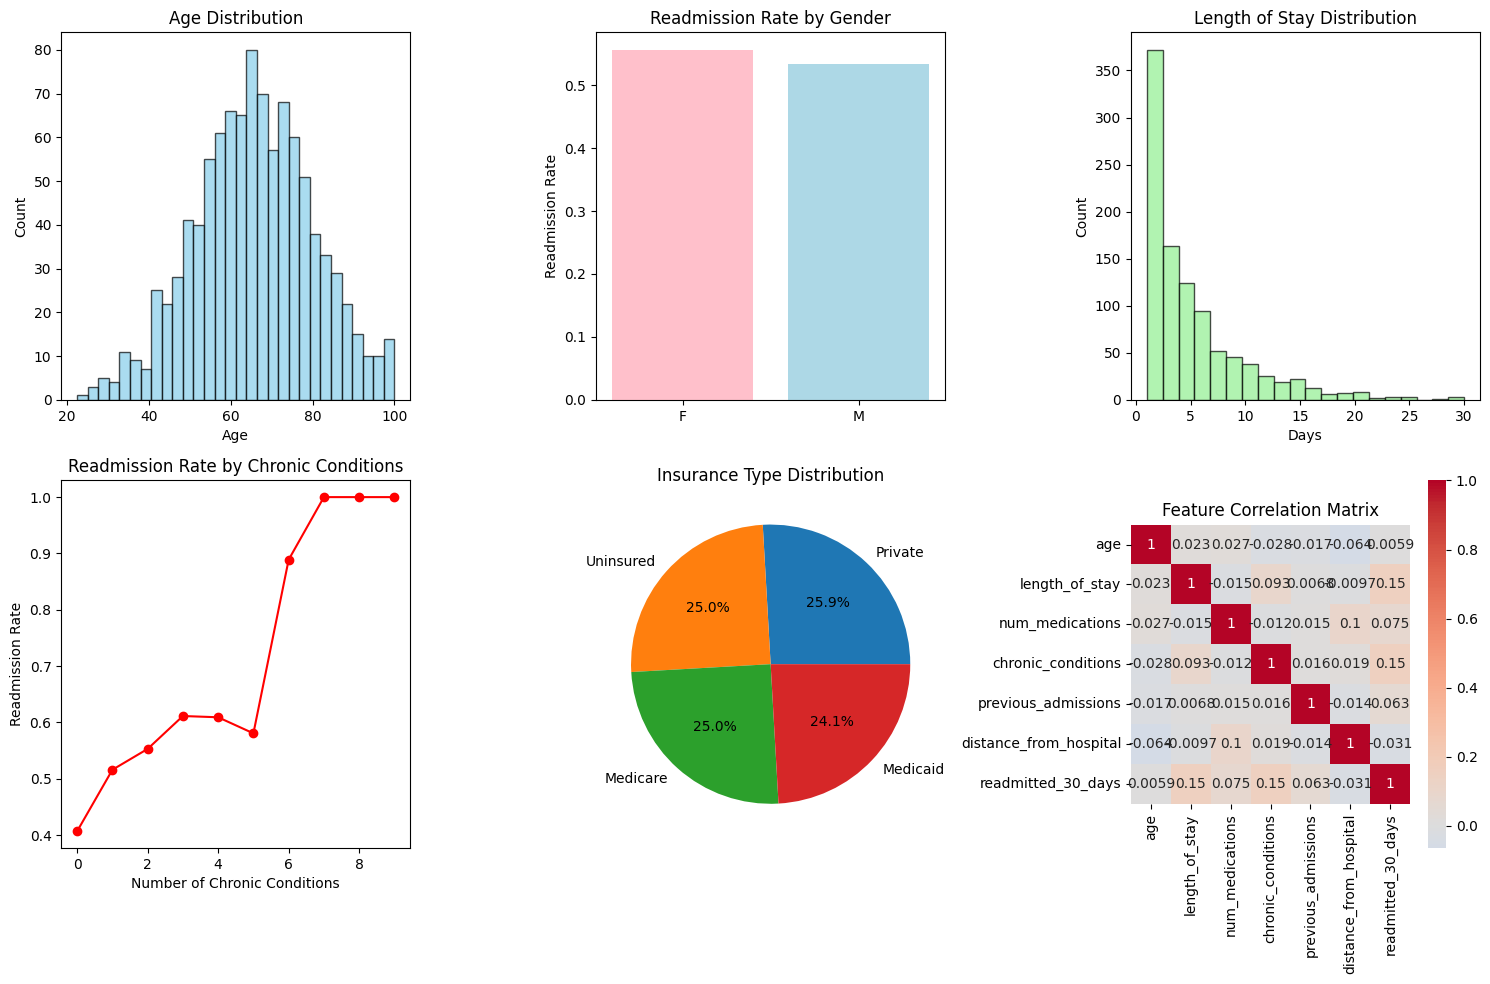

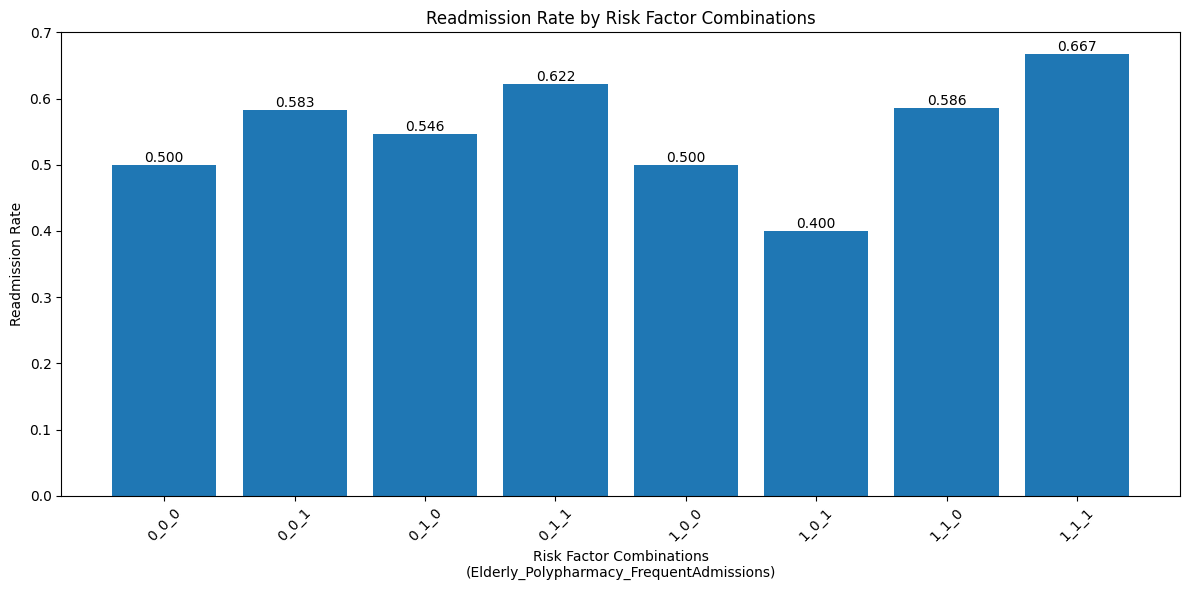

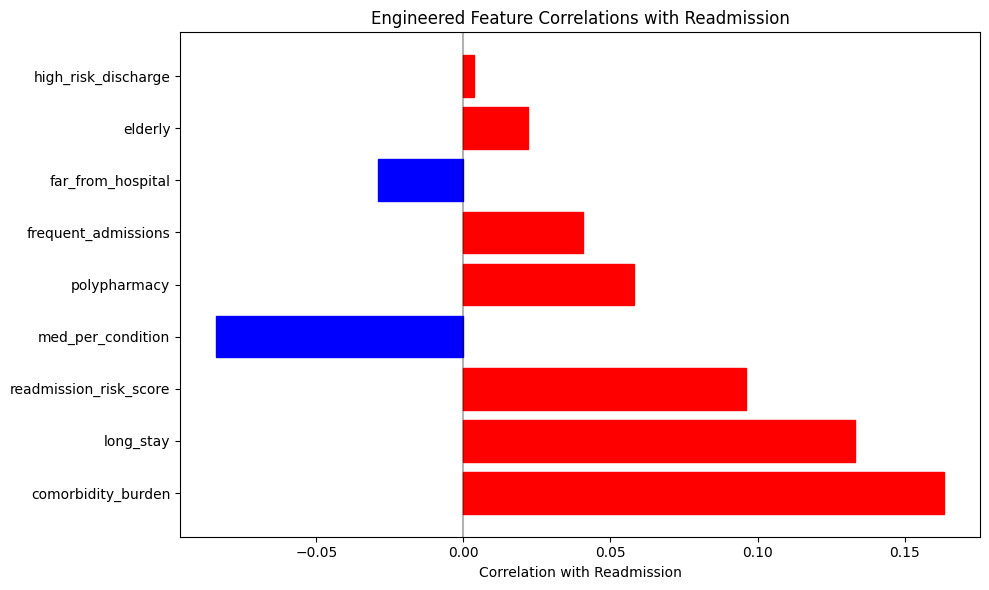

Step 8: Preparing final dataset...
  - Selected 20 features for modeling
  - Final dataset shape: (1000, 20)
  - Target distribution:
    - No readmission: 456 (45.60%)
    - Readmission: 544 (54.40%)
Step 9: Generating data quality report...
Data Quality Report:
  - Dataset shape: (1000, 25)
  - Missing values: 0
  - Duplicate rows: 0
  - Data types: {dtype('int64'): 14, dtype('float64'): 7, dtype('O'): 3, CategoricalDtype(categories=['<50', '50-65', '65-80', '>80'], ordered=True, categories_dtype=object): 1}

=== Data Preprocessing Complete ===
Ready for modeling with 20 features and 1000 samples
Step 7: Scaling features...
  - Scaled 20 features
  - Training set shape: (800, 20)
  - Test set shape: (200, 20)


In [17]:
# Load your data
df = generate_sample_data(1000)  # or load your actual data

# Run the complete preprocessing pipeline
X, y, feature_names, preprocessor, processed_df, bias_report, quality_report = run_preprocessing_pipeline(df)

# Now you can use X and y for model training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features if needed
X_train_scaled, X_test_scaled = preprocessor.scale_features(X_train, X_test)